In [1]:
%matplotlib inline


# Sıfırdan NLP: Diziden Diziye Çeviri ve Dikkat

`torchtext` metin ön işleme işlemlerinin bir çoğunu içinde barındırır ve bizim için uygular.

Bu notebook da fransızcadan ingilizceye çeviri yapan bir model inşaa edeceğiz..

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... farkettiyseniz farklı derecelerde başarılar mevcuttur.

[sequence
to sequence network](https://arxiv.org/abs/1409.3215) 'ler için ilgili makaleye göz atabilirsiniz. Burada iki
tekrarlayan sinir ağları, bir diziyi dönüştürmek için birlikte çalışır,
temel mantık budur. Bir kodlayıcı ağı, bir giriş dizisini bir vektöre yoğunlaştırır,
ve bir kod çözücü ağı bu vektörü yeni bir diziye açar.


[attention
mechanism](https://arxiv.org/abs/1409.0473): Biraz önce bahsettik ya, kodlayıcı ağından genel vektör bir kod çözücü ağında tekrardan sıralı bir dizi şeklinde çıktı verir diye. İştem tam da bu noktada dikkat mekanızmasına ihtiyaç duyarız.Çünkü kod çözücünün
giriş dizisinin belirli bir aralığına odaklanmayı dikkat mekanızması ile öğreniriz.

**Önerilen Kaynaklar:**

-  https://pytorch.org/ Kurulum talimatları için
-  `/beginner/deep_learning_60min_blitz` genel olarak PyTorch'a başlamak için
-  `/beginner/pytorch_with_examples` geniş ve derin bir genel bakış için
-  `/beginner/former_torchies_tutorial` eski Lua Torch kullanıcısıysanız


Sequence to Sequence networks'leri bilmek faydalı olur ve onların nasıl çalıştığına dair bilgileri aşağıdaki kaynaklardan edinebilirsiniz.

-  [Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation](https://arxiv.org/abs/1406.1078)_
-  [Sequence to Sequence Learning with Neural
   Networks](https://arxiv.org/abs/1409.3215)_
-  [Neural Machine Translation by Jointly Learning to Align and
   Translate](https://arxiv.org/abs/1409.0473)_
-  [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)_


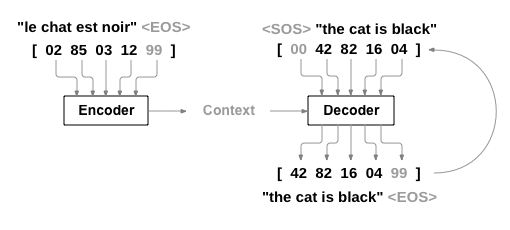

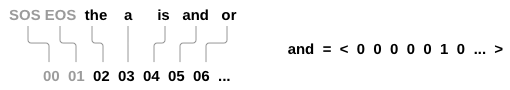

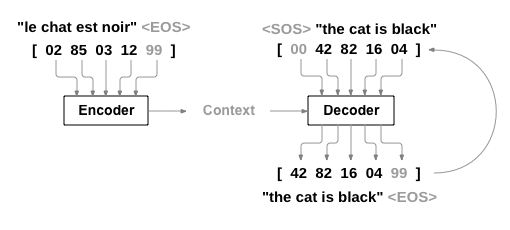

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Veri dosyalarını hazırlayalım.

Bu projenin verileri, binlerce ingilizce-fransızca çeviriden oluşan veri setidir.

[This question on Open Data Stack
Exchange](https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages),
 https://tatoeba.org/, https://tatoeba.org/eng/downloads, https://www.manythings.org/anki/

Yukarıda verdiğim siteler size farklı squence to squence projeleriniz de yardımcı olacaktır.

Elimizdeki veri seti çok büyük olduğundan biz projede çalışabilmemiz adına ``data/eng-fra.txt`` indireceğiz. Bu test aşağıda verilen yapıdadır.

::

    I am cold.    J'ai froid.

.. Not::
   indirme linki
   [burada](https://download.pytorch.org/tutorial/data.zip)
   ve indirdikten sonra ilgili dizine çıkartalım. yani data/ dizinine..



Yapacağımız işlem Karakter düzeyinde RNN'de kullanılan karakter kodlamasına benzer.
Bir dildeki her kelimeyi tek sıcak olarak temsil edeceğiz.Bundan dolayı ise elimizdeki vektör büyük olacak. Bununla birlikte, biraz hile yapacağız ve verileri yalnızca birkaçını kullanacak şekilde kırpacağız.


Daha sonra ağların girdileri ve hedefleri olarak kullanmak için kelime başına benzersiz bir dizine ihtiyacımız olacak. Tüm bunları takip etmek için, kelime → indeks (word2index) ve indeks → kelime (index2word) sözlüklerinin yanı sıra daha sonra nadir kelimelerin yerini alacak her kelimenin bir word2count sayısı olan Lang adında bir yardımcı sınıf kullanacağız.




In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  #  SOS ve EOS sayısı

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Dosyaların tümü Unicode'dadır, basitleştirmek için Unicode'u ASCII'ye çevireceğiz, her şeyi küçük harf yapacağız ve noktalama işaretlenin bir çoğunu kırpacağız.



In [4]:
# Unicode string to plain ASCII, kod için teşekkürler.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Harf olmayan karakterleri küçük harf, kırpın ve kaldırın.
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

Veri dosyasını okumak için dosyayı satırlara ayıracağız ve ardından satırları çiftlere ayıracağız. 




In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("txt'i okumaya başladım...")

    # Dosyayı oku ve satırlara ayır
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Her satırı çiftlere ayırın ve normalleştirin
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Çiftleri ters çevirin, Lang örnekleri yapın
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Çok sayıda örnek cümle olduğundan ve hızlı bir şekilde eğitmek istediğimizden, veri setini yalnızca kısa ve basit cümlelerle kırpacağız. Burada maksimum uzunluk 10 kelimedir (bitiş noktalama işaretleri dahil) ve "I am" veya "He is" vb. biçimine çevrilen cümleleri filtreliyoruz.




In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Verileri hazırlamak için tam süreç şu şekilde:

- Metin dosyasını okuyun ve satırlara bölün, satırları çiftlere ayırın
- Metni normalleştirin, uzunluğa ve içeriğe göre filtreleyin
- Çiftler halinde cümlelerden kelime listeleri yapın




In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("%s cümle çiftini okudum.." % len(pairs))
    pairs = filterPairs(pairs)
    print("%s cümle çiftine kırptım.." % len(pairs))
    print("kelimeleri sayıyorum..")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("sayılan kelimeler:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

txt'i okumaya başladım...
135842 cümle çiftini okudum..
10599 cümle çiftine kırptım..
kelimeleri sayıyorum..
sayılan kelimeler:
fra 4345
eng 2803
['je commence a peine .', 'i m just beginning .']


## Seq2Seq Model

Tekrarlayan Sinir Ağı veya RNN'ler; sıralı olarak gelen verilerde, sonraki adımlar için girdi olarak bir sonraki veri ve kendi çıktısını kullanır.

[Sequence to Sequence network](https://arxiv.org/abs/1409.3215), [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf), bu pdf te belirtilen model kodlayıc ve kod çözücü olmak üzere iki adet RNN den oluşur.. Kodlayıcı bir giriş dizisini alır ve tek bir vektör çıktı verir sonrasında kod çözücü bu vektörü alır ve bir çıktı dizisi üretmek için kullanır.

Tek bir RNN ile dizi tahmininin aksine, bütün girişin olduğu RNN yapısı tek bir çıktı verir, seq2seq modeli bizi dizi çıktısından kurtarır ve buda onu iki dil arasında çeviri yapmak adına ideal kılar.


### Encoder Yapısı

seq2seq ağının kodlayıcısı giriş cümlesindeki her kelimeden bir miktar değer çıkaran bir rnn'dir.
Her giriş kelimesi için kodlayıcı
bir vektör ve bir gizli durum çıktısı verir ve gizli durumu
sonraki rnn hücresi için giriş kabul edilir.


Encoder Mimarisi

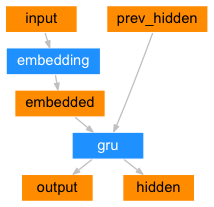

Encoder Kodlaması

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder Yapısı

Kodlayıcının çıkış vektörlerini alan başka bir RNN'dir ve
çeviriyi oluşturmak için bir sözcük dizisi çıkarır.




#### Basit Decoder

En basit seq2seq kod çözücüde, yalnızca kodlayıcının son çıkışını kullanırız.
Bu son çıktı,  *bağlam vektörü - context vector* olarak adlandırılır.Bu bağlam
kod çözücünün ilk gizli durumu olarak kullanılır..

Kod çözmenin her adımında, kod çözücüye bir giriş belirteci verilir ve
gizli durum İlk giriş belirteci, ``<SOS>`` dizesinin başlangıcıdır.
İlk gizli durum bağlam vektörüdür (kodlayıcının
son gizli durum).


Decoder Mimarisi

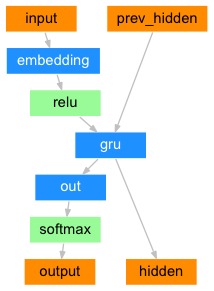

Decoder Kodlaması

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Attention Decoder

Kodlayıcı ve kod çözücü arasında yalnızca bağlam vektörü geçirilirse,
bu tek vektör tüm cümleyi kodlamak için bütün yükü taşır. Bütün bağlam bilgisini içerir kısaca.

Dikkat (Attention),Kod çözücünün kendi çıktılarının her adımı için kodlayıcının çıktılarına odaklanmasını sağlar. İlk olarak bir dizi *dikkat ağırlığı* hesaplıyoruz.Kodlayıcının çıkış vektörleri dikkat ağırlıklarıa ile çarpılır. Sonuç olarak kod çözücüye yardımcı olan kodlamada `attn_applied` adı altında yapılan ve giriş dizisinin bilgisini içererek çıkışta anlamı kelimeleri bulmamızı sağlayan bir mekanızmadır. 
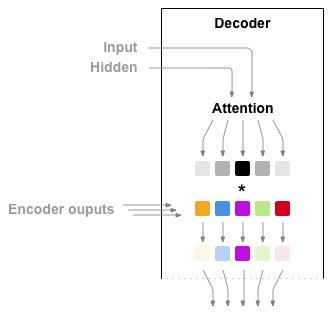

Dikkat ağırlıklarının hesaplanması başka bir ileri besleme ile yapılır.
Giriş olarak kod çözücünün girişini ve gizli durumunu kullanarak ``attn`` katmanında dikkat mekanizmasının ağırlıkları hesaplanır..

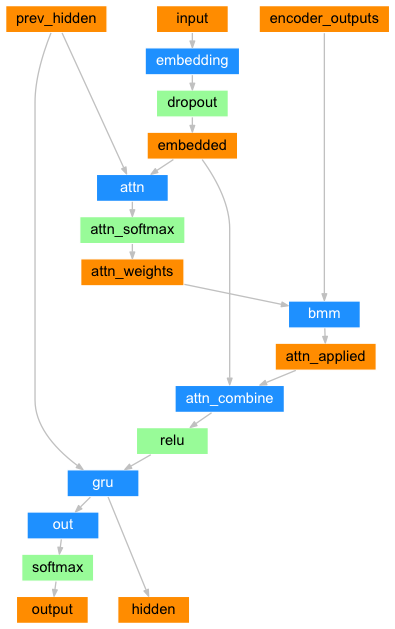





In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Bu makaleye de göz atabirsiniz. Farklı bir dikkat mekanızmasını anlatır. [Effective Approaches to Attention-based Neural Machine
  Translation](https://arxiv.org/abs/1508.04025)

## Eğitim

### Eğitim Verilerinin Hazırlanması

Modelimizi eğitmek için, her çift için bir giriş tensörüne ihtiyacımız olacak (dizinler
giriş cümlesindeki kelimeler) ve hedef tensör (kelimelerin indeksleri)
hedef cümle). Bu vektörleri oluştururken her iki diziye de EOS belirtecini ekleyeceğiz.




In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Modelimizi eğitelim.

Modelimizi eğitmek için giriş cümlesini kodlayıcı aracılığıyla çalıştırıyoruz.Her çıktının ve en son gizli durumu takip ediyoruz. Sonra bunlar kod çözücüye verilir.
ilk girişi olarak ``<SOS>`` belirteci ve son gizli durum ise
ilk gizli durum olarak kodlayıcıye verilir..

"Teacher forcing", gerçek hedef çıktılarını üretmek için  kod çözücünün tahminini bir sonraki giriş olarak kullanmak yerine, sonraki her girişi yeni giriş olarak kullanır. 
"Teacher forcing", daha hızlı yakınsamasına neden olur, ancak [eğitilmiş
ağdan yararlanılırsa, istikrarsızlık görüntülenebilir
](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).


In [12]:
teacher_forcing_ratio = 0.5 # ne kadar kullanacağız.


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Bir sonraki girdi olarak hedefi besleyin
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # teacher forcing kullanmadan: bir sonraki girdi olarak kendi tahminlerini kullan
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() 

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Bu, geçerli süre ve ilerleme yüzdesi verildiğinde geçen süreyi ve kalan tahmini süreyi yazdırmak için yardımcı bir işlevdir.



In [13]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Tüm eğitim süreci şöyledir:

- Bir zamanlayıcı başlat
- İyileştiricileri ve ölçütü başlat
- Eğitim çiftleri seti oluşturun
- Çizim için boş kayıp dizisini başlatın

Ardından birçok kez ``train`` diyoruz ve ara sıra ilerlemeyi (%) yazdırıyoruz.
örnek sayısı, şimdiye kadar geçen süre, tahmini süre) ve ortalama kayıp.



In [14]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Her print_every'yi sıfırla
    plot_loss_total = 0  # Her plot_every'i sıfırlay

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Sonuçları çizme






In [15]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Değerlendirme

Değerlendirme çoğunlukla eğitimle aynıdır, ancak herhangi bir hedef yoktur.
Biz sadece her adım için kod çözücünün tahminlerini kendisine geri besleriz.
Bir Word'ü her tahmin ettiğinde, onu çıkış dizisine ekliyoruz ve
orada durduğumuz EOS jetonunu tahmin ediyor.


In [16]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Eğitim ve Değerlendirme


In [18]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 19s (- 18m 36s) (5000 6%) 2.8363
2m 35s (- 16m 48s) (10000 13%) 2.2788
3m 50s (- 15m 20s) (15000 20%) 1.9451
5m 5s (- 14m 0s) (20000 26%) 1.7173
6m 21s (- 12m 42s) (25000 33%) 1.5014
7m 36s (- 11m 25s) (30000 40%) 1.3299
8m 52s (- 10m 8s) (35000 46%) 1.2012
10m 8s (- 8m 52s) (40000 53%) 1.0701
11m 24s (- 7m 36s) (45000 60%) 0.9708
12m 40s (- 6m 20s) (50000 66%) 0.8593
13m 56s (- 5m 4s) (55000 73%) 0.8121
15m 14s (- 3m 48s) (60000 80%) 0.7434
16m 32s (- 2m 32s) (65000 86%) 0.6716
17m 48s (- 1m 16s) (70000 93%) 0.6255
19m 4s (- 0m 0s) (75000 100%) 0.5365


In [19]:
evaluateRandomly(encoder1, attn_decoder1)

> desole de ce que j ai fait .
= i m sorry for what i did .
< i am sorry for what i did . <EOS>

> je suis enchante d etre ici .
= i am delighted to be here .
< i am delighted to be here . <EOS>

> c est une etudiante qui etudie serieusement .
= she is a student who studies very hard .
< she is a student who studies very hard . <EOS>

> je suis le porte parole de cette institution .
= i m the spokesperson for this organization .
< i m the for for this this . <EOS>

> ils sont tous semblables a moi .
= they are all alike to me .
< they are all alike me me . <EOS>

> il est encore celibataire .
= he s still single .
< he s still single . <EOS>

> vous etes incroyablement talentueux .
= you re incredibly talented .
< you re incredibly talented . <EOS>

> nous sommes dans le petrin .
= we re in trouble .
< we re in trouble water . <EOS>

> nous partons a la pension .
= we re retiring .
< we re retiring . <EOS>

> il est anglais .
= he s an englishman .
< he s english . <EOS>



### Dikkati Görselleştirmek

Dikkat mekanizmasının faydalı bir özelliği, oldukça yorumlanabilir olmasıdır.
Belirli encoder çıkışlarını ağırlıklandırmak için kullanıldığı için
giriş dizisi, ağın en çok nereye odaklandığını görebiliriz.


In [22]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [21]:
def showAttention(input_sentence, output_words, attentions):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>
input = elle est trop petit .
output = she s too trusting . <EOS>
input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>
input = c est un jeune directeur plein de talent .
output = he is a young but . <EOS>


<ipython-input-21-bd20d73fb52f>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-21-bd20d73fb52f>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)
